In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns 
from model_utils import * 

from sklearn.utils.class_weight import compute_class_weight
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_classif


In [62]:
figsize=[5,5]

def compute_search_stats(df):
    """Compute the search rate and hit rate"""
    search_conducted = df['predicted_outcome']
    contraband_found = df['target']
    n_searches  = search_conducted.shape[0]
    n_hits      = contraband_found.sum()

    # Filter out counties with too few searches
    if (n_searches) < 30:
        hit_rate = None
    else:
        hit_rate = n_hits / n_searches

    return(pd.Series(data = {        
        'n_searches': n_searches,
        'n_hits': n_hits,        
        'hit_rate': hit_rate
    }))


def compute_search_stats_cloth(df):
    """Compute the search rate and hit rate"""
    cloth_removed = (df['Removal of more than just outer clothing']) & (df['Gender']=='female')
    cloth_removed_target_true = (cloth_removed) & (df['target'])
    n_cloth_removed  = cloth_removed.sum()
    n_hits      = cloth_removed_target_true.sum()

    # Filter out counties with too few searches
    if (n_cloth_removed) < 1:
        hit_rate = None
    else:
        hit_rate = n_hits / n_cloth_removed

    return(pd.Series(data = {        
        'n_searches': n_cloth_removed,
        'n_hits': n_hits,        
        'hit_rate': hit_rate
    }))


def generate_comparison_scatter(df, ax, station, race, field, color):
    """Generate scatter plot comparing field for white drivers with minority drivers"""
    race_location_agg = df.groupby(['station','Officer-defined ethnicity']).apply(compute_search_stats).reset_index().dropna()
    race_location_agg = race_location_agg.pivot(index='station', columns='Officer-defined ethnicity', values='hit_rate')
    ax = race_location_agg.plot.scatter(ax=ax, x='white', y=race, s=50, label=race, color=color)
    return ax


def generate_comparison_scatter_gender(df, ax, station, race, field, color):
    """Generate scatter plot comparing field for white drivers with minority drivers"""
    race_location_agg = df.groupby(['station','Gender']).apply(compute_search_stats).reset_index().dropna()
    race_location_agg = race_location_agg.pivot(index='station', columns='Gender', values='hit_rate')
    ax = race_location_agg.plot.scatter(ax=ax, x='male', y=race, s=50, label=race, color=color)
    return ax




def format_scatter_chart(ax, station, field):
    """Format and label to scatter chart"""
    ax.set_xlabel('{} - White female'.format(field))
    ax.set_ylabel('{} - Non-White female'.format(field))
    ax.set_title("{} ".format(field))
    lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    ax.legend()
    return ax

def generate_comparison_scatters(df, station):
    """Generate scatter plots comparing search rates of white drivers with black and hispanic drivers"""
    fig, axes = plt.figure(),plt.axes()
    generate_comparison_scatter(df, axes, station, 'black', 'hit_rate', 'red')
    generate_comparison_scatter(df, axes, station, 'mixed', 'hit_rate', 'orange')
    generate_comparison_scatter(df, axes, station, 'asian', 'hit_rate', 'blue')
    #generate_comparison_scatter(df, axes, station, 'other', 'hit_rate', 'green')
    format_scatter_chart(axes, station, 'Search sucess rate per station')
    
    return fig


def generate_comparison_scatters_genders(df, station):
    """Generate scatter plots comparing search rates of white drivers with black and hispanic drivers"""
    fig, axes = plt.figure(),plt.axes()
    generate_comparison_scatter_gender(df, axes, station, 'female', 'hit_rate', 'red')
    format_scatter_chart(axes, station, 'Search sucess rate per station')
    
    return fig



def generate_comparison_scatter_cloth(df, ax, station, race, field, color):
    """Generate scatter plot comparing field for white drivers with minority drivers"""
    race_location_agg = df.groupby(['station','Officer-defined ethnicity']).apply(compute_search_stats_cloth).reset_index().dropna()
    race_location_agg = race_location_agg.pivot(index='station', columns='Officer-defined ethnicity', values='hit_rate')
    print(race_location_agg)
    ax = race_location_agg.plot.scatter(ax=ax, x='white', y=race, s=50, label=race, color=color)
    return ax


def generate_comparison_scatters_cloth(df, station):
    """Generate scatter plots comparing search rates of white drivers with black and hispanic drivers"""
    fig, axes = plt.figure(),plt.axes()
    generate_comparison_scatter_cloth(df, axes, station, 'black', 'hit_rate', 'red')
    generate_comparison_scatter_cloth(df, axes, station, 'mixed', 'hit_rate', 'orange')
    generate_comparison_scatter_cloth(df, axes, station, 'asian', 'hit_rate', 'blue')
    #generate_comparison_scatter_cloth(df, axes, station, 'other', 'hit_rate', 'green')
    format_scatter_chart(axes, station, 'Search sucess rate when clothes are removed')
    
    return fig

In [3]:
file_in = 'data/test_prod_set1_cleaned.csv'
file_out = ''

target = 'target'

# Read data

df = pd.read_csv(file_in)
df.head()


df_raw=pd.read_csv("data/test_prod_set1.csv")


In [64]:
df.tail()

,Unnamed: 0,observation_id,Type,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,Latitude,...,outcome_updated,proba,valid,target,year,month,day,day_of_week,hour,minute
750,1672,634b8afc-f234-4d44-847a-2f26bf356abf,person search,female,10-17,white,police and criminal evidence act 1984 (section 1),offensive weapons,nottinghamshire,None,...,True,0.355081,True,False,2020,1,29,2,19,19
751,1700,d719e678-bff1-4027-b3c8-17a16608bbfd,person search,male,25-34,white,misuse of drugs act 1971 (section 23),controlled drugs,nottinghamshire,None,...,True,0.510936,True,True,2020,1,30,3,14,14
752,1728,f743274a-87c9-4663-8e9f-a14cdb163a2e,person search,male,18-24,black,misuse of drugs act 1971 (section 23),controlled drugs,nottinghamshire,None,...,True,0.515505,True,False,2020,1,31,4,19,19
753,1734,daa864f8-b3ae-4a4f-92e2-f9ff9f95b9b8,person search,female,over 34,white,misuse of drugs act 1971 (section 23),controlled drugs,nottinghamshire,None,...,True,0.515505,True,False,2020,1,31,4,23,4
754,1757,3af4308e-bc40-48e4-af51-3f3e258c1050,person and vehicle search,male,25-34,white,misuse of drugs act 1971 (section 23),controlled drugs,durham,54.68806,...,True,0.575220,True,True,2020,2,1,5,21,35


In [65]:

compute_search_stats(df)

n_searches    755.000000
n_hits        215.000000
hit_rate        0.284768
dtype: float64

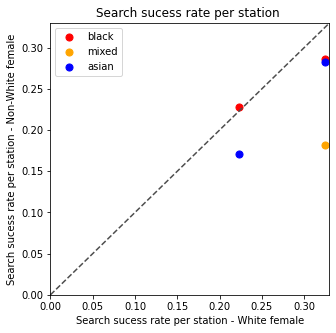

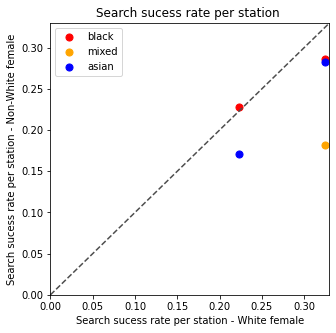

In [66]:
plt.rcParams["figure.figsize"]=[5,5]
generate_comparison_scatters(df, 'essex')

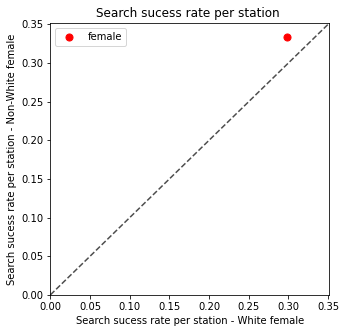

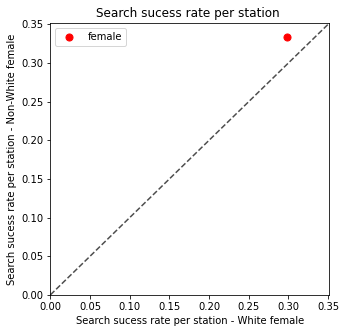

In [67]:
plt.rcParams["figure.figsize"]=[5,5]
generate_comparison_scatters_genders(df, 'essex')

In [78]:

df[df[target]].shape

(215, 25)

In [79]:
df[~df[target]].shape

(540, 25)

In [80]:
df.shape[0]

755

Text(0.5, 0, 'Search Sucess Rate')

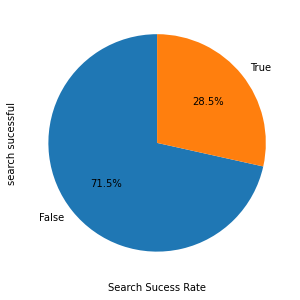

In [75]:
df["search sucessful"]=df["target"]
plt.rcParams["figure.figsize"]=[5,5]
sucess_rate=df["search sucessful"].value_counts()/df.shape[0]
sucess_rate.plot.pie(autopct='%1.1f%%',startangle=90)
plt.xlabel("Search Sucess Rate")


In [76]:

df["Object of search"].unique()
weights=compute_class_weight(class_weight='balanced',classes=df["Object of search"].unique(), y=df["Object of search"])
weighs_map = {}

i=0
for obj in df["Object of search"].unique():
    weighs_map[obj]=weights[i]
    i+=1
    
df["weight"]=df["Object of search"].map(weighs_map)

df.head()
#weights.sum()

df_resampled=df.groupby("Object of search").sample(
    n=1000,
    replace=True,
    weights=df["weight"],
    random_state=1,
)


Text(0.5, 0, 'Search ratio per object of search')

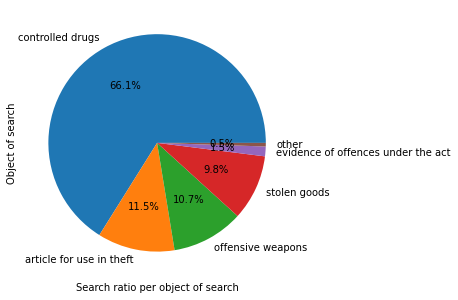

In [39]:
plt.rcParams["figure.figsize"]=[5,5]
object_search=df["Object of search"].value_counts()/df.shape[0]
object_low_search=object_search[object_search < 0.0095]
object_search=object_search.drop(index=object_low_search.index.to_list())

object_low_search_s=pd.Series([object_low_search.sum()],index=['other'])
object_search=object_search.append(object_low_search_s)
object_search.plot.pie(autopct='%1.1f%%')
plt.ylabel("Object of search")
plt.xlabel("Search ratio per object of search")

Text(0, 0.5, '# of searches per station')

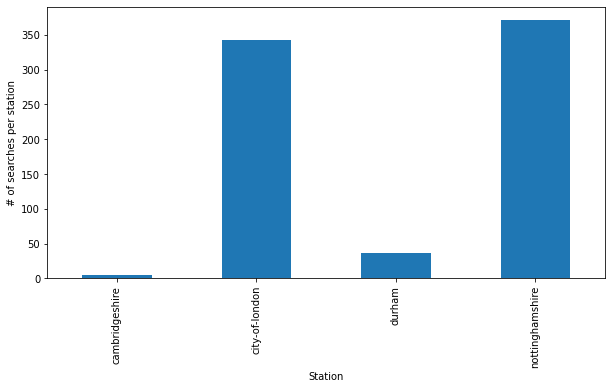

In [87]:
plt.rcParams["figure.figsize"]=[10,5]
object_search=df["station"].value_counts()
object_search=object_search.sort_index()
object_search.plot.bar()
plt.xlabel("Station")
plt.ylabel("# of searches per station")


#object_low_search=object_search[object_search < 0.05]
#object_search=object_search.drop(index=object_low_search.index.to_list())

#object_low_search_s=pd.Series([object_low_search.sum()],index=['other'])
#object_search=object_search.append(object_low_search_s)
#object_search.plot.pie(autopct='%1.1f%%')
#plt.ylabel("Station")
#plt.xlabel("Search ratio per station")

Text(0, 0.5, '# of searches per year')

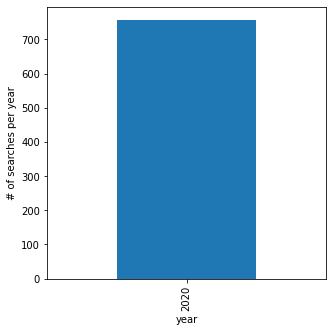

In [41]:
plt.rcParams["figure.figsize"]=[5,5]
object_search=df["year"].value_counts()
object_search=object_search.sort_index()
object_search.plot.bar()
plt.xlabel("year")
plt.ylabel("# of searches per year")

Text(0, 0.5, 'Age range')

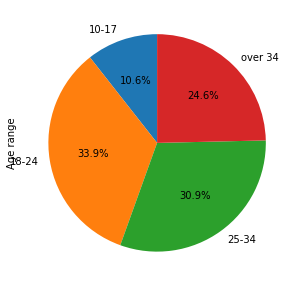

In [81]:
plt.rcParams["figure.figsize"]=[5,5]
object_search=df["Age range"].value_counts()/df.shape[0]
object_search=object_search.sort_index()
object_search.plot.pie(autopct='%1.1f%%',startangle=90)
plt.ylabel("Age range")

Text(0, 0.5, 'Gender')

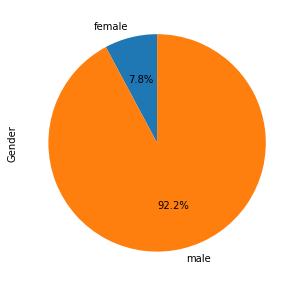

In [82]:
plt.rcParams["figure.figsize"]=[5,5]
object_search=df["Gender"].value_counts()/df.shape[0]
object_search=object_search.sort_index()
object_search.plot.pie(autopct='%1.1f%%',startangle=90)
plt.ylabel("Gender")

Text(0, 0.5, 'Officer-defined ethnicity')

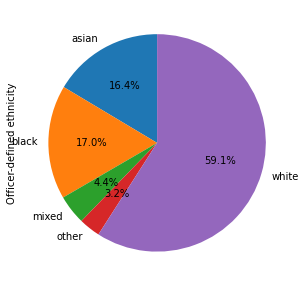

In [83]:
plt.rcParams["figure.figsize"]=[5,5]
object_search=df["Officer-defined ethnicity"].value_counts()/df.shape[0]
object_search=object_search.sort_index()
object_search.plot.pie(autopct='%1.1f%%',startangle=90)
plt.ylabel("Officer-defined ethnicity")

Text(0, 0.5, 'Type of search')

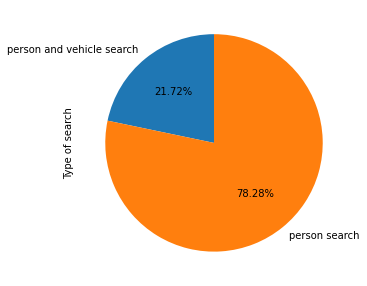

In [84]:


plt.rcParams["figure.figsize"]=[5,5]
object_search=df["Type"].value_counts()/df.shape[0]
object_search=object_search.sort_index()
object_search.plot.pie(autopct='%1.2f%%',startangle=90)
plt.ylabel("Type of search")

Text(0, 0.5, 'Part of a policing operation')

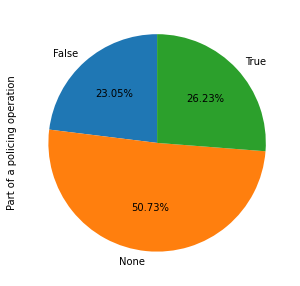

In [85]:
plt.rcParams["figure.figsize"]=[5,5]
object_search=df["Part of a policing operation"].value_counts()/df.shape[0]
object_search=object_search.sort_index()
object_search.plot.pie(autopct='%1.2f%%',startangle=90)
plt.ylabel("Part of a policing operation")

In [86]:
df_raw["Officer-defined ethnicity"].value_counts()

White    1071
Black     302
Asian     250
Mixed      86
Other      50
Name: Officer-defined ethnicity, dtype: int64

In [96]:

likelihood = search_likelihood(df_raw,"Officer-defined ethnicity" )

Asian   NaN
Black   NaN
Mixed   NaN
Other   NaN
White   NaN
asian   NaN
black   NaN
mixed   NaN
other   NaN
white   NaN
dtype: float64




In [ ]:
from pandas_profiling import ProfileReport
profile=ProfileReport(df,title='report')
profile.to_file("profile_report.html")

In [24]:
df_sucess_rate_ethnicity_station = pd.read_csv("data/model_discrimination_precision.csv")
df_sucess_rate_ethnicity_station=df_sucess_rate_ethnicity_station.set_index("Unnamed: 0")
#df_sucess_rate_ethnicity_station=df_sucess_rate_ethnicity_station.fillna(0)
#df_sucess_rate_ethnicity_station=df_sucess_rate_ethnicity_station.drop("durham")
df_sucess_rate_ethnicity_station.head()

df_station_with_discriminate = df_sucess_rate_ethnicity_station[(df_sucess_rate_ethnicity_station.abs()>0.05).any(axis=1)].shape[0]
df_station_pos_discrimination= df_sucess_rate_ethnicity_station[(df_sucess_rate_ethnicity_station>0.05).any(axis=1)].shape[0]
df_station_neg_discrimination= df_sucess_rate_ethnicity_station[(df_sucess_rate_ethnicity_station<-0.05).any(axis=1)].shape[0]
df_station_non_black_asian_discrimination = df_sucess_rate_ethnicity_station.drop(columns=["black","asian"])
df_station_mixed_other_discrimination = df_station_non_black_asian_discrimination[(df_station_non_black_asian_discrimination.abs()>0.05).any(axis=1)].shape[0] 
avg_discrimination_stations = df_sucess_rate_ethnicity_station[(df_sucess_rate_ethnicity_station.abs()>0.05).any(axis=1)].sum(axis=1).mean()



print(df_station_with_discriminate)
print(df_station_mixed_other_discrimination)
print(df_station_pos_discrimination)
print(df_station_neg_discrimination)
print(avg_discrimination_stations)

#df_sucess_rate_ethnicity_station.mean(axis=1)

17
11
11
9
0.03300703718405853


In [88]:
#df_sucess_rate, df_sucess_rate_group = verify_no_discrimination_1(X_test, y_true, sensitive_column='Officer-defined ethnicity', min_samples=30)
df_sucess_rate_ethnicity = pd.read_csv("data/df_sucess_rate_ethnicity.csv")
df_sucess_rate_ethnicity_station = pd.read_csv("data/df_sucess_rate_ethnicity_station.csv")

df_sucess_rate_gender=pd.read_csv("data/df_sucess_rate_gender.csv")
df_sucess_rate_gender_station=pd.read_csv("data/df_sucess_rate_gender_station.csv")

df_sucess_rate_object=pd.read_csv("data/df_sucess_rate_object.csv")
df_sucess_rate_object_ethnicity=pd.read_csv("data/df_sucess_rate_object_ethnicity.csv")
df_sucess_rate_object_gender=pd.read_csv("data/df_sucess_rate_object_gender.csv")
df_sucess_rate_object_station=pd.read_csv("data/df_sucess_rate_object_station.csv")

Text(0.5, 1.0, 'Search sucess rate per ethnicity group')

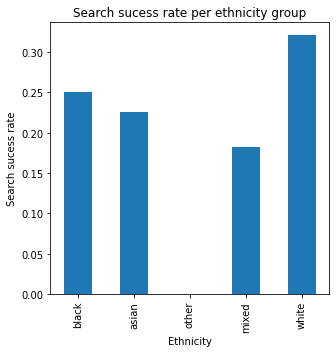

In [89]:
#df_sucess_rate_ethnicity=df_sucess_rate_ethnicity.rename({'Unnamed: 0': 'Station'})
plt.rcParams["figure.figsize"]=[5,5]
df_sucess_rate_ethnicity=df_sucess_rate_ethnicity.set_index('Unnamed: 0')
df_sucess_rate_ethnicity.plot.bar(legend=False)
plt.xlabel("Ethnicity")
plt.ylabel("Search sucess rate")
plt.title("Search sucess rate per ethnicity group")

In [25]:
df_sucess_rate_ethnicity_station
#df_sucess_rate_ethnicity_station=df_sucess_rate_ethnicity_station.set_index("Unnamed: 0")
#df_sucess_rate_ethnicity_station=df_sucess_rate_ethnicity_station.sort_index()

,other,black,asian,mixed
Unnamed: 0,,,,
dyfed-powys,NaN,NaN,NaN,NaN
kent,0.006550,-0.019621,0.021620,0.022494
lincolnshire,NaN,0.011631,NaN,NaN
devon-and-cornwall,NaN,0.011019,NaN,NaN
avon-and-somerset,0.054067,-0.036215,-0.006227,0.035997
humberside,NaN,0.000000,0.000000,NaN
northumbria,-0.016278,0.028151,-0.004426,NaN
south-yorkshire,0.151958,0.030079,-0.012202,NaN
derbyshire,NaN,0.010019,0.016880,NaN


In [40]:
palette = {'asian': 'C0',
               'black': 'C1',
               'other': 'C2',
               'mixed': 'C3'}


Text(0, 0.5, 'Negative difference in search sucess rate compared to whites ')

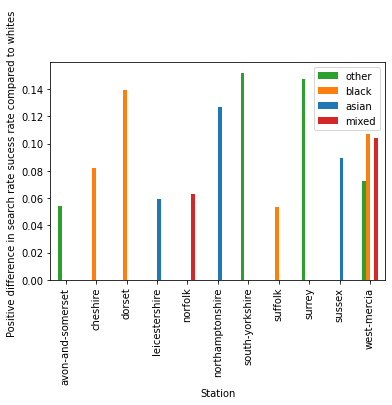

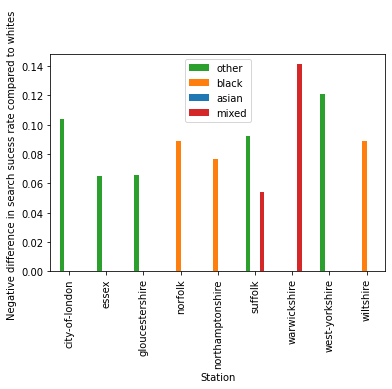

In [41]:
df_sucess_rate_ethnicity_station=df_sucess_rate_ethnicity_station.fillna(0)
df_sucess_rate_ethnicity_station=df_sucess_rate_ethnicity_station.sort_index()
df_sucess_rate_ethnicity_station_pos = df_sucess_rate_ethnicity_station[(df_sucess_rate_ethnicity_station>0.05).any(axis=1)]
df_sucess_rate_ethnicity_station_neg = df_sucess_rate_ethnicity_station[(df_sucess_rate_ethnicity_station<-0.05).any(axis=1)]

df_sucess_rate_ethnicity_station_pos[df_sucess_rate_ethnicity_station_pos>0.05].plot.bar(color=palette)
plt.xlabel("Station")
plt.ylabel("Positive difference in search rate sucess rate compared to whites ")

df_sucess_rate_ethnicity_station_neg[df_sucess_rate_ethnicity_station_neg<-0.05].abs().plot.bar(color=palette)
plt.xlabel("Station")
plt.ylabel("Negative difference in search sucess rate compared to whites ")



In [91]:
df["station"].unique()
df_sucess_rate_ethnicity_station.head()

,black,asian,other,mixed
Unnamed: 0,,,,
city-of-london,0.004991,-0.051429,NaN,NaN
durham,NaN,NaN,NaN,NaN
nottinghamshire,-0.038961,-0.041656,NaN,-0.142857


In [271]:
df_sucess_rate_ethnicity_station.loc['leicestershire']

asian    0.042153
black   -0.000536
other   -0.024916
mixed         NaN
Name: leicestershire, dtype: float64

Text(0.5, 1.0, 'Difference in Search sucess rate per station')

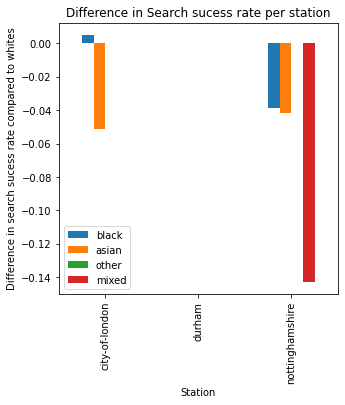

In [92]:
#TODO remove from plots entries with zeros

#df_sucess_rate_ethnicity_station=df_sucess_rate_ethnicity_station.rename({'Unnamed: 0': 'Station'})
#df_sucess_rate_ethnicity_station=df_sucess_rate_ethnicity_station.set_index('Unnamed: 0')
#df_sucess_rate_ethnicity_station=df_sucess_rate_ethnicity_station.sort_index()
df_sucess_rate_ethnicity_station.plot.bar()
plt.rcParams["figure.figsize"]=[7,3]
plt.xlabel("Station")
plt.ylabel("Difference in search sucess rate compared to whites")
plt.title("Difference in Search sucess rate per station")

In [46]:
df_sucess_rate_ethnicity_station_first = pd.read_csv("data/df_sucess_rate_ethnicity_station_first.csv")
df_sucess_rate_ethnicity_station_second = pd.read_csv("data/df_sucess_rate_ethnicity_station_second.csv")
df_sucess_rate_ethnicity_station_third = pd.read_csv("data/df_sucess_rate_ethnicity_station_third.csv")
df_sucess_rate_ethnicity_station_forth = pd.read_csv("data/df_sucess_rate_ethnicity_station_forth.csv")

In [47]:
df_sucess_rate_ethnicity_station_first.head()

,Unnamed: 0,asian,other,black,mixed
0,lancashire,0.000000,NaN,0.000000,NaN
1,gloucestershire,NaN,NaN,-0.138226,NaN
2,suffolk,NaN,NaN,NaN,NaN
3,dyfed-powys,NaN,NaN,NaN,NaN
4,west-yorkshire,-0.005209,NaN,0.069452,NaN


Text(0.5, 1.0, 'Difference in station search sucess rate per ethnicity for first trimester')

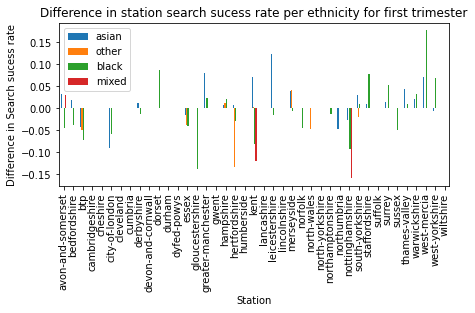

In [48]:
df_sucess_rate_ethnicity_station_first=df_sucess_rate_ethnicity_station_first.set_index('Unnamed: 0')
df_sucess_rate_ethnicity_station_first=df_sucess_rate_ethnicity_station_first.sort_index()
df_sucess_rate_ethnicity_station_first.plot.bar()
plt.rcParams["figure.figsize"]=[7,3]
plt.xlabel("Station")
plt.ylabel("Difference in Search sucess rate")
plt.title("Difference in station search sucess rate per ethnicity for first trimester")

Text(0.5, 1.0, 'Difference in station search sucess rate per ethnicity for second trimester')

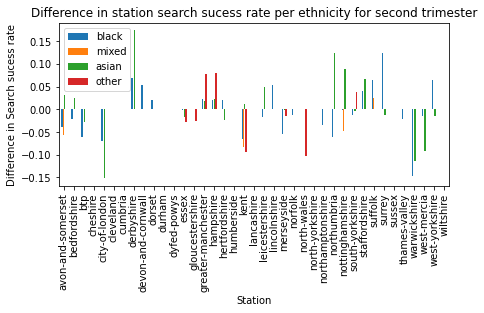

In [148]:
df_sucess_rate_ethnicity_station_second=df_sucess_rate_ethnicity_station_second.set_index('Unnamed: 0')
df_sucess_rate_ethnicity_station_second=df_sucess_rate_ethnicity_station_second.sort_index()
df_sucess_rate_ethnicity_station_second.plot.bar()
plt.rcParams["figure.figsize"]=[7,3]
plt.xlabel("Station")
plt.ylabel("Difference in Search sucess rate")
plt.title("Difference in station search sucess rate per ethnicity for second trimester")

Text(0.5, 1.0, 'Difference in station search sucess rate per ethnicity for third trimester')

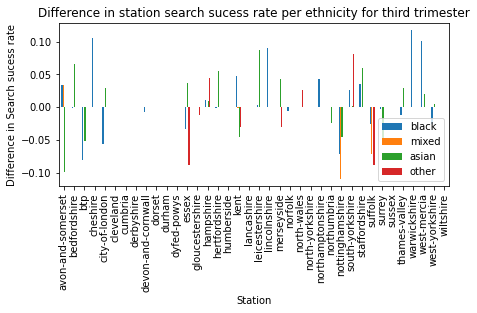

In [160]:
#df_sucess_rate_ethnicity_station_third=df_sucess_rate_ethnicity_station_third.set_index('Unnamed: 0')
df_sucess_rate_ethnicity_station_third=df_sucess_rate_ethnicity_station_third.sort_index()
df_sucess_rate_ethnicity_station_third.plot.bar()
plt.rcParams["figure.figsize"]=[7,3]
plt.xlabel("Station")
plt.ylabel("Difference in Search sucess rate")
plt.title("Difference in station search sucess rate per ethnicity for third trimester")

Text(0.5, 1.0, 'Difference in station search sucess rate per ethnicity for forth trimester')

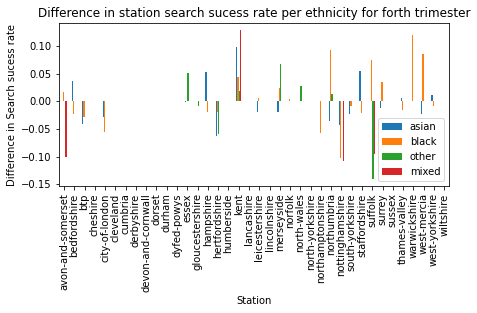

In [159]:
#df_sucess_rate_ethnicity_station_forth=df_sucess_rate_ethnicity_station_forth.set_index('Unnamed: 0')
df_sucess_rate_ethnicity_station_forth=df_sucess_rate_ethnicity_station_forth.sort_index()
df_sucess_rate_ethnicity_station_forth.plot.bar()
plt.rcParams["figure.figsize"]=[7,3]
plt.xlabel("Station")
plt.ylabel("Difference in Search sucess rate")
plt.title("Difference in station search sucess rate per ethnicity for forth trimester")

Text(0.5, 1.0, 'Search sucess rate per gender')

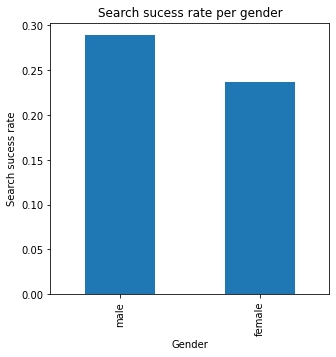

In [94]:
#df_sucess_rate_gender=df_sucess_rate_gender.rename({'Unnamed: 0': 'Station'})
df_sucess_rate_gender=df_sucess_rate_gender.set_index('Unnamed: 0')
df_sucess_rate_gender.plot.bar(legend=False)
plt.rcParams["figure.figsize"]=[5,5]
plt.xlabel("Gender")
plt.ylabel("Search sucess rate")
plt.title("Search sucess rate per gender")


Text(0.5, 1.0, 'Difference in station search sucess rate per gender')

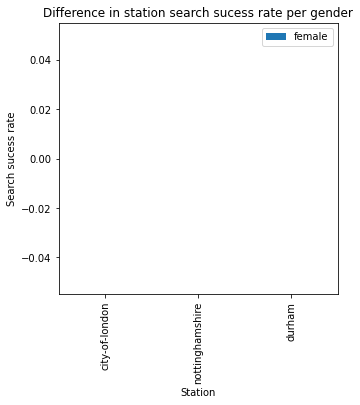

In [95]:
df_sucess_rate_gender_station=df_sucess_rate_gender_station.rename({'Unnamed: 0': 'Station'})
df_sucess_rate_gender_station=df_sucess_rate_gender_station.set_index('Unnamed: 0')
df_sucess_rate_gender_station.plot.bar()
plt.xlabel("Station")
plt.ylabel("Search sucess rate")
plt.title("Difference in station search sucess rate per gender")



In [96]:
print(df_sucess_rate_object)

                            Unnamed: 0  Object of search
0                     controlled drugs          0.339321
1                    offensive weapons          0.123457
2             article for use in theft          0.190476
3                         stolen goods          0.256757
4  articles for use in criminal damage               NaN
5   evidence of offences under the act               NaN
6                             firearms               NaN


Text(0.5, 1.0, 'Search sucess rate per object of search')

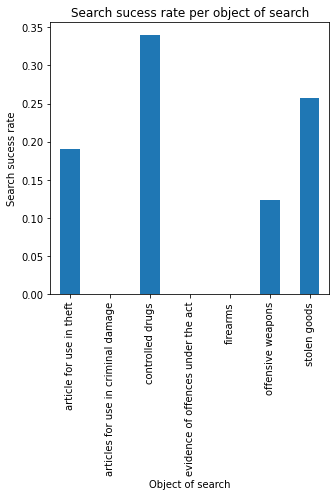

In [99]:
#df_sucess_rate_object=df_sucess_rate_object.rename({'Unnamed: 0': 'Station'})
#df_sucess_rate_object=df_sucess_rate_object.set_index('Unnamed: 0')
#df_sucess_rate_object=df_sucess_rate_object.drop("crossbows")
#df_sucess_rate_object=df_sucess_rate_object.drop("evidence of wildlife offences")
#df_sucess_rate_object=df_sucess_rate_object.drop("detailed object of search unavailable")
#df_sucess_rate_object=df_sucess_rate_object.drop("goods on which duty has not been paid etc.")


df_sucess_rate_object=df_sucess_rate_object.sort_index()
df_sucess_rate_object.plot.bar(legend=False)
plt.rcParams["figure.figsize"]=[5,5]
plt.xlabel("Object of search")
plt.ylabel("Search sucess rate")
plt.title("Search sucess rate per object of search")


In [170]:
df_sucess_rate_object_gender.head()

,female,other
Unnamed: 0,,
controlled drugs,-0.063189,0.06196
offensive weapons,-0.004941,NaN
stolen goods,0.070417,NaN
article for use in theft,0.041534,NaN
articles for use in criminal damage,0.006853,NaN


Text(0.5, 1.0, 'Difference in object search sucess rate between females and males')

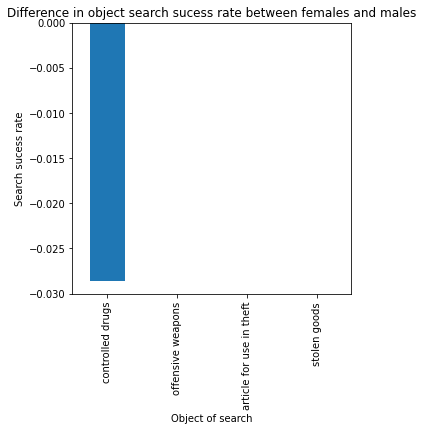

In [101]:
#df_sucess_rate_object_gender=df_sucess_rate_object_gender.rename({'Unnamed: 0': 'Station'})
df_sucess_rate_object_gender=df_sucess_rate_object_gender.set_index('Unnamed: 0')
#df_sucess_rate_object_gender=df_sucess_rate_object_gender.drop(columns=['other'])
plt.rcParams["figure.figsize"]=[5,5]
#df_sucess_rate_object_gender=df_sucess_rate_object_gender.drop("game or poaching equipment")
df_sucess_rate_object_gender.plot.bar(legend=False)
plt.xlabel("Object of search")
plt.ylabel("Search sucess rate")
plt.title("Difference in object search sucess rate between females and males")


Text(0.5, 1.0, 'Object search sucess rate per ethnicity compared to white population')

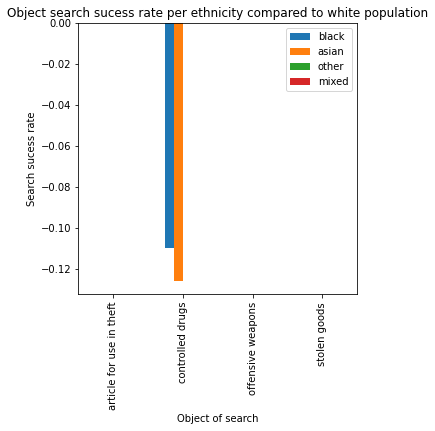

In [102]:
df_sucess_rate_object_ethnicity=df_sucess_rate_object_ethnicity.set_index('Unnamed: 0')

#df_sucess_rate_object_ethnicity=df_sucess_rate_object_ethnicity.drop("crossbows")
#df_sucess_rate_object_ethnicity=df_sucess_rate_object_ethnicity.drop("evidence of wildlife offences")
#df_sucess_rate_object_ethnicity=df_sucess_rate_object_ethnicity.drop("detailed object of search unavailable")
#df_sucess_rate_object_ethnicity=df_sucess_rate_object_ethnicity.drop("goods on which duty has not been paid etc.")
#df_sucess_rate_object_ethnicity=df_sucess_rate_object_ethnicity.drop("game or poaching equipment")
#df_sucess_rate_object_ethnicity=df_sucess_rate_object_ethnicity.drop("fireworks")

plt.rcParams["figure.figsize"]=[5,5]
df_sucess_rate_object_ethnicity=df_sucess_rate_object_ethnicity.sort_index()
df_sucess_rate_object_ethnicity.plot.bar()
plt.xlabel("Object of search")
plt.ylabel("Search sucess rate")
plt.title("Object search sucess rate per ethnicity compared to white population")


In [ ]:
# object search rate by age

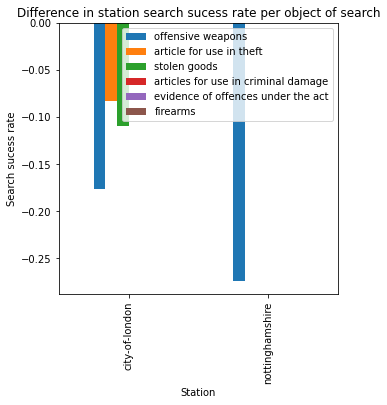

In [103]:
df_sucess_rate_object_station=df_sucess_rate_object_station.set_index('Unnamed: 0')
df_sucess_rate_object_station.plot.bar()
plt.xlabel("Station")
plt.ylabel("Search sucess rate")
plt.title("Difference in station search sucess rate per object of search")
plt.legend(loc='upper right')


In [ ]:
# cloth removal vs age and ethnicity
# 2D histogram of latitudes and longitudes : for several months
# officer etnicity vs self defined etchnicity ( make an heatmap)
# likelihood of search ( normalized by population)
# Search sucess rate per station etchnnicity and month
# TO DO use scatter plots
# Check if when officer defined etchinity is differed than self defined etchinity then
# there is more discrimination


In [48]:
# TO DO exclude metropolitan or not ?
df_cloth_removal_ethnicity=pd.read_csv("data/df_cloth_removal_ethnicity.csv")
df_cloth_removal_ethnicity_age=pd.read_csv("data/df_cloth_removal_ethnicity_age.csv")
df_cloth_removal_gender=pd.read_csv("data/df_cloth_removal_gender.csv")
df_cloth_removal_gender_age=pd.read_csv("data/df_cloth_removal_gender_age.csv")
df_cloth_removal_ethnicity_age_female=pd.read_csv("data/df_cloth_removal_ethnicity_age_female.csv")




Text(0.5, 1.0, 'Cloth removal rate per ethnicity')

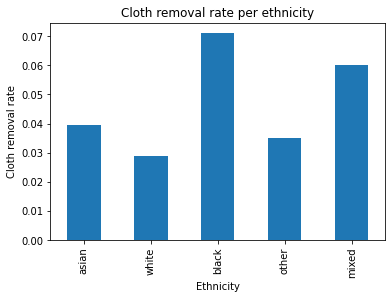

In [44]:
#df_cloth_removal_ethnicity=df_cloth_removal_ethnicity.rename({'Unnamed: 0': 'Station'})
df_cloth_removal_ethnicity=df_cloth_removal_ethnicity.set_index('Unnamed: 0')
df_cloth_removal_ethnicity.plot.bar(legend=False)
plt.xlabel("Ethnicity")
plt.ylabel("Cloth removal rate")
plt.title("Cloth removal rate per ethnicity")


Text(0.5, 1.0, 'Cloth removal rate per gender')

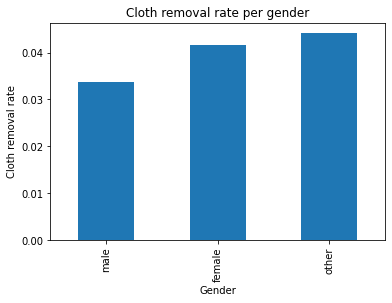

In [47]:
#df_cloth_removal_gender=df_cloth_removal_gender.set_index('Unnamed: 0')
df_cloth_removal_gender.plot.bar(legend=False)
plt.xlabel("Gender")
plt.ylabel("Cloth removal rate")
plt.title("Cloth removal rate per gender")

#Use this plot


In [66]:
df_cloth_removal_ethnicity_age.head()

,Unnamed: 0,asian,black,other,mixed
0,18-24,0.017334,0.061633,0.012175,0.049223
1,25-34,0.000876,0.044420,0.005880,0.043504
2,over 34,0.000659,0.021346,-0.003219,0.017833
3,10-17,0.015676,0.023502,0.005082,0.010455
4,under 10,NaN,-0.017595,NaN,NaN


Index(['18-24', '25-34', 'over 34', '10-17'], dtype='object', name='Unnamed: 0')


Text(0.5, 1.0, 'Cloth removal rate per age and ethnicity')

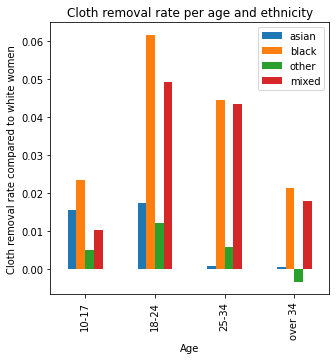

In [61]:
#df_cloth_removal_ethnicity_age.rename({'Unnamed: 0':'Age range'})
#df_cloth_removal_ethnicity_age=df_cloth_removal_ethnicity_age.set_index('Unnamed: 0')
df_cloth_removal_ethnicity_age_=df_cloth_removal_ethnicity_age.drop("under 10")
print(df_cloth_removal_ethnicity_age_.index)
df_cloth_removal_ethnicity_age_=df_cloth_removal_ethnicity_age_.sort_index()
df_cloth_removal_ethnicity_age_.plot.bar()
plt.xlabel("Age")
plt.ylabel("Cloth removal rate compared to white women")
plt.title("Cloth removal rate per age and ethnicity")


Type    person and vehicle search  person search  vehicle search
target                                                          
False                    0.764016       0.809402        0.701754
True                     0.235984       0.190598        0.298246


Text(0.5, 1.0, 'Search sucess rate per type of operation')

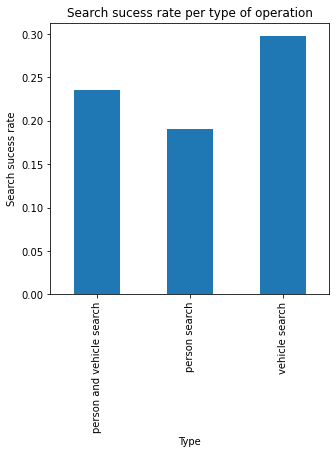

In [38]:
plt.rcParams["figure.figsize"]=[5,5]
crosstab_eth = pd.crosstab(df[target],df["Type"], normalize='columns')
print(crosstab_eth)
crosstab_eth.iloc[1].plot.bar()

plt.xlabel("Type")
plt.ylabel("Search sucess rate")
plt.title("Search sucess rate per type of operation")
#There are more black women in ages 18-24

Part of a policing operation     False      True   missing
target                                                    
False                         0.799059  0.766191  0.801685
True                          0.200941  0.233809  0.198315


Text(0.5, 1.0, 'Search sucess rate per if part of policing operation')

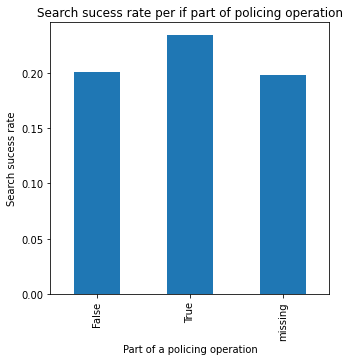

In [40]:
plt.rcParams["figure.figsize"]=[5,5]
crosstab_eth = pd.crosstab(df[target],df["Part of a policing operation"], normalize='columns')
print(crosstab_eth)
crosstab_eth.iloc[1].plot.bar()

plt.xlabel("Part of a policing operation")
plt.ylabel("Search sucess rate")
plt.title("Search sucess rate per if part of policing operation")
#There are more black women in ages 18-24

In [55]:
df_cloth_removal_gender_age.head()

,Unnamed: 0,female,other
0,18-24,-0.003617,0.004150
1,25-34,0.013470,0.041112
2,over 34,0.021519,0.033161
3,10-17,-0.001970,-0.015887
4,under 10,0.096631,NaN


<AxesSubplot:ylabel='Frequency'>

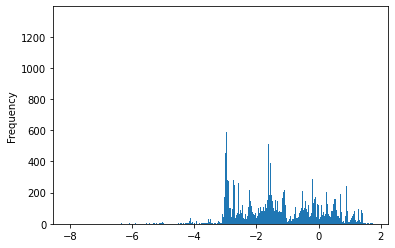

In [108]:
df[df[target]]["Longitude"].plot.hist(bins=1000)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([49.892149  , 49.96466607, 50.03718314, 50.10970021, 50.18221728,
        50.25473435, 50.32725142, 50.39976849, 50.47228556, 50.54480263,
        50.6173197 , 50.68983677, 50.76235384, 50.83487091, 50.90738798,
        50.97990505, 51.05242212, 51.12493919, 51.19745626, 51.26997333,
        51.3424904 , 51.41500747, 51.48752454, 51.56004161, 51.63255868,
        51.70507575, 51.77759282, 51.85010989, 51.92262696, 51.99514403,
        52.0676611 , 52.14017817, 52.21269524, 52.28521231, 52.35772938,
        52.43024645, 52.50276352, 52.57528059, 52.64779766, 52.72031473,
        52.7928318 , 52.86534887, 52.93786594, 53.01038301, 53.08290008,
        53.15541715, 53.22793422, 53.30045129, 53.37296836, 53.44548543,
        53.5180025 , 

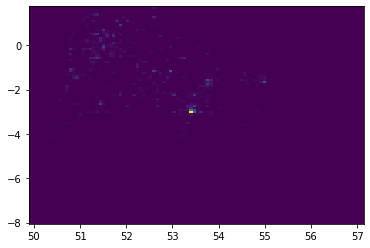

In [100]:
plt.hist2d(df["Latitude"].dropna(),df["Longitude"].dropna(),bins=100,density=True)




(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([49.892149  , 49.96466607, 50.03718314, 50.10970021, 50.18221728,
        50.25473435, 50.32725142, 50.39976849, 50.47228556, 50.54480263,
        50.6173197 , 50.68983677, 50.76235384, 50.83487091, 50.90738798,
        50.97990505, 51.05242212, 51.12493919, 51.19745626, 51.26997333,
        51.3424904 , 51.41500747, 51.48752454, 51.56004161, 51.63255868,
        51.70507575, 51.77759282, 51.85010989, 51.92262696, 51.99514403,
        52.0676611 , 52.14017817, 52.21269524, 52.28521231, 52.35772938,
        52.43024645, 52.50276352, 52.57528059, 52.64779766, 52.72031473,
        52.7928318 , 52.86534887, 52.93786594, 53.01038301, 53.08290008,
        53.15541715, 53.22793422, 53.30045129, 53.37296836, 53.44548543,
        53.5180025 , 

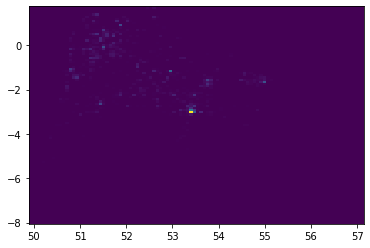

In [101]:
plt.hist2d(df[df[target]]["Latitude"].dropna(),df[df[target]]["Longitude"].dropna(),bins=100,density=True)

In [224]:

df_=df.copy()
df_=df_.drop(columns=['Unnamed: 0','ethnicity','observation_id'])
categorical_features = list(
        df_.select_dtypes(include=['object']).columns)

numerical = df_.drop(categorical_features, axis=1).columns


In [225]:
categorical_features

['Type',
 'Part of a policing operation',
 'Gender',
 'Age range',
 'Officer-defined ethnicity',
 'Legislation',
 'Object of search',
 'station']

In [226]:
mutual_info = mutual_info_classif(
    X=df_[categorical_features],
    y=df_[target])

ValueError: could not convert string to float: 'person search'

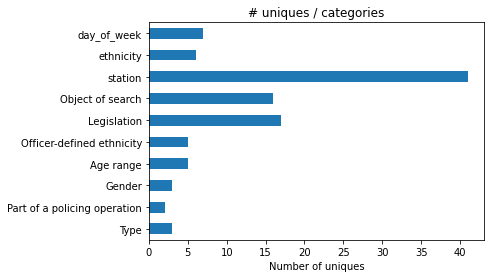

In [111]:
number_of_uniques_per_category = df_.loc[:, categorical_features].nunique()
number_of_uniques_per_category.plot(kind='barh',
                                    title='# uniques / categories');
plt.xlabel('Number of uniques')
plt.show()

In [112]:
pd.Series({
    colname: df_[colname].value_counts()
    for colname in numerical
}, index=numerical).plot.barh();

TypeError: no numeric data to plot

In [113]:
corr_matrix = df_.drop(categorical_features, axis=1).corr(method='spearman')
corr_matrix

,Latitude,Longitude,Outcome linked to object of search,Removal of more than just outer clothing,target,Outcome_true,year,month,hour,minute
Latitude,1.000000,-0.487287,0.057244,-0.008810,-0.027094,-0.057554,0.036787,0.002914,-0.023967,0.177194
Longitude,-0.487287,1.000000,0.020542,-0.012812,0.013530,0.061279,-0.011878,0.005985,0.018328,-0.215818
Outcome linked to object of search,0.057244,0.020542,1.000000,0.033868,0.725014,0.485174,-0.024504,-0.008886,0.009666,-0.007380
Removal of more than just outer clothing,-0.008810,-0.012812,0.033868,1.000000,0.045706,0.040182,-0.007422,-0.013456,-0.027221,-0.018368
target,-0.027094,0.013530,0.725014,0.045706,1.000000,0.766822,-0.008884,-0.007269,0.004268,-0.006393
Outcome_true,-0.057554,0.061279,0.485174,0.040182,0.766822,1.000000,-0.043618,-0.017575,-0.000946,-0.019809
year,0.036787,-0.011878,-0.024504,-0.007422,-0.008884,-0.043618,1.000000,-0.086988,-0.000541,0.013738
month,0.002914,0.005985,-0.008886,-0.013456,-0.007269,-0.017575,-0.086988,1.000000,0.014469,0.012378
hour,-0.023967,0.018328,0.009666,-0.027221,0.004268,-0.000946,-0.000541,0.014469,1.000000,-0.001686
minute,0.177194,-0.215818,-0.007380,-0.018368,-0.006393,-0.019809,0.013738,0.012378,-0.001686,1.000000


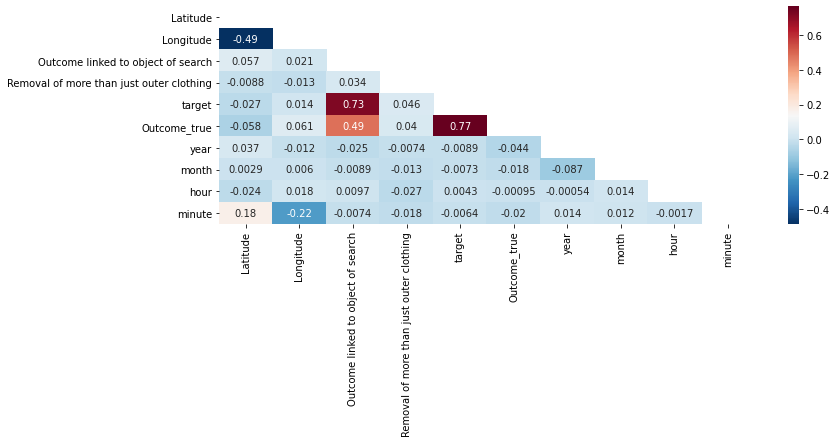

In [114]:
#Plot of correlation matrix 
lower_triangle_mask = np.triu(np.ones(corr_matrix.shape)).astype(np.bool)
cor_mat_lower = corr_matrix.mask(lower_triangle_mask)

plt.figure(figsize = (12,4)) # <-- just sets the figure size 

sns.heatmap(cor_mat_lower, 
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); #

In [ ]:
numerical_features=df_[numerical].drop(columns=[target])
mutual_info = mutual_info_classif(
    X=numerical_features.fillna(0),  # as with so much in scikit, it does not like missing data
    y=df_[target])


In [ ]:
numerical_mutual_info = pd.Series(mutual_info, index=numerical_features.columns).sort_values()
numerical_mutual_info

In [ ]:
mutual_info = mutual_info_classif(
    X=df_[categorical_features],
    y=df_[target])

In [ ]:
categorical_mutual_info = pd.Series(mutual_info, index=categorical_features).sort_values()
categorical_mutual_info